# The Prisoners Riddle

### Setup

An exploration of a counter intuative riddle, best explained [here](https://www.youtube.com/watch?v=iSNsgj1OCLA).

Briefly: there are 100 prisoners, each has a number on their chests. They are able to see their own number and the numbers of others. Now there is a room in which there are 100 boxed. Each box also has a number on it, also from 1 to 100. In each box is yet another number on a piece of paper. The number in the box is not necessarily the same as the number on the box.

Each prisoner must enter the room one at a time and is allowed to open up to 50 boxes. They must find the piece of paper that has their number on it. If all prisoners find their own number then they are all allowed to go free, if not then the are all executed!

In addition, the prisoners are not allowed to confer afterwards about what they have seen. They are, however, allowed to talk about their strategy before hand all together.

If they go in and open boxes at random then each prisoner has a probability of 1/2 of finding their own number. HOwever, to win the game they all need to suceed. Each prisoner is an independent trial, so the chance of all prisoners suceeding is an unimaginably small number, namely $(\frac{1}{2})^{100}$, for all purposes zero.

However, there is a strategy that gives them a chance of about 1/3, which is much better. In fact it has been shown that this strategy is optimal, they can't do better than that.

Here is the strategy, each prisoner goes into the room and they open the box that corresponds to the number on their chest. So prisoner number 20 opens box number 20. They are not more likley to win with this strategy as it stands as there is no correlation between the numbers on the box and the numbers in the box. Now, they take the paper from the box, and open that box with the number from the paper in their hand. So let's say prisoner 20 opens box 20, in box 20 it says 32, so they open box 32, they repeat this procedure until they find their own number, or they run out of tries. The very strange this is that the probability of each prisoner getting their own number is still 1/, but the probability of them all getting their number is now around 1/3. There is an explanation for this, but let's first simply simulate the situation to test our intuation. Note a simulation is of course not a proof, but we can demonstrate beyond all reasonable doubt that the probability of sucess for everyone is no longer 1/2^100.

### Simulation

In [1]:
import numpy as np

Slightly overkill to make this a class, it's just a dictionary essentially!

In [26]:
class BoxRoom:
    
    def __init__(self, size=100):
        
        self.size = size
        ints = np.random.choice(range(1, 101), size=100, replace=False)
        self.boxes = {i + 1: ints[i] for i in range(size)}
        
    def __getitem__(self, key):
        return self.boxes[key]

In [47]:
br = BoxRoom()
br[12]

50

In [48]:
prisoners = np.random.choice(range(1, 101), size=100, replace=False)

In [68]:
def prisoner_trial(prisoner, br, limit=50):
    """
    Simulates a trial for the prisoner. Returns true if sucessful, false if not.
    """
    
    is_found = False
    trials = 0
    current_number = prisoner
    while (not is_found) and (trials < limit):
        current_number = br[current_number]
        trials += 1
        if current_number == prisoner:
            is_found = True
    return is_found

Now write a function to go through all the prisoners, return the number of sucessful prisoners.

In [71]:
def trial_all(prisoners, br):
    sucesses = []
    for prisoner in prisoners:
        sucesses.append(prisoner_trial(prisoner, br))
    return sum(sucesses)

OK, and let's do the whole thing multiple times,  interested in the distribution of the number of sucesses, and ultimately in the total in which they are all sucesses.

In [80]:
reps = 10001
wins = []
for i in range(reps):
    prisoners = np.random.choice(range(1, 101), size=100, replace=False)
    br = BoxRoom()
    wins.append(trial_all(prisoners, br))

We can already see that we have some 100 sucesses in our list, and the random strategy says that you would never see that. And indeed this is more like 30% as we predicted.

In [86]:
wins.count(100)/len(wins)

0.3093690630936906

And let's look at the distribution of these wins. What does it look like?

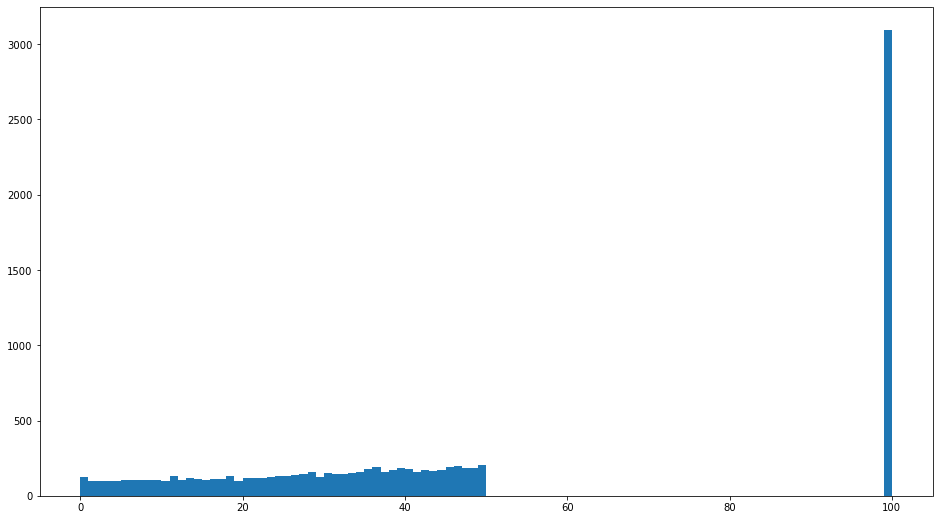

In [85]:
import matplotlib.pyplot as plt

plt.subplots(figsize = (16, 9))
plt.hist(wins, bins=100);

So that's interesting. There are actually a lot of instances where this strategy does a lot worse than random in terms of the total wins. But this game doesn't reward almost, so you can see that the times when we get all right are quite common. This is a weird distribution though right.

We can see that the mean wins is still about 1/2, so we actually haven't altered this at all, it is the shape of the distribution that we have changed.

In [88]:
np.mean(wins)

49.99450054994501

### Explanation

Now why is this?

We can think of the room full of boxes as contianing loops. For example, box 7 opens box 12, opens box 57, opens box 62, opens box 2, opens box 17, opens box 7 again, and we've gone full circle. The prisoner stops at at the last stage of the loop as by design the last step is the prisoners own number. The 'algorithm' that they follow always puts them on the loop which contains their own number by design. So they are gaurenteed to find that number if they follow that loop until completion. However, they are as far away within that loop from their own number as is possilbe, so they will only get to their own number if the loop that contains their number is 50 steps or less. So for each prisoner the condition for their own sucess is that their own loop has 50 or less steps in it.

Now consider the arrangement of the room, as all numbers are sampled eventually by all the prisoners (as they all have different numbers), then they will sample all loops that are in the room. They will then all succeed if the setup of the room has no loops that are greater than 50. At least some will be unsucsesful if there is at least one loop greater than 50. Note of course that there will actually only ever be one loop that is greater than 50. So the probability for sucess for the whole procedure is that the biggest loop in the setup is 50 or less.

We can work out this probability actually, but let's have a look at some randomly generated rooms and ask how big the biggest loop is in each case.

In [131]:
def biggest_loop(br):
    sampled_numbers = set()
    # We'll work out the size of the loop for every starting number, but note that we can also record
    # numbers that we have already visited, this isn't strictly necessary, but speeds things up.
    biggest_loop = 0
    for i in range(1, 101):
        if i in sampled_numbers:
            continue
        loop_out = False
        current_number = i
        loop_size = 0
        while not loop_out:
            loop_size += 1
            current_number = br[current_number]
            sampled_numbers.add(current_number)
            if current_number == i:
                loop_out = True
        if loop_size > biggest_loop:
            biggest_loop = loop_size
    return biggest_loop
            

An interesting thing to note is that the code for finding the biggest loop is actually quite similar to the code I wrote for the prisoners to sample the boxes. This is no coincidence. The prisoners are in effect running an algorithm to find the size of the biggest loop (or more precisely to query if the biggest loop is greater than 50).

And now let's look at this distribution.

In [132]:
biggest_loop_sizes = []
reps = 50000
for r in range(reps):
    br = BoxRoom()
    biggest_loop_sizes.append(biggest_loop(br))

In [133]:
np.mean(biggest_loop_sizes)

62.8481

And how often is the biggest loop greater than 50.

In [134]:
np.mean([m <= 50 for m in biggest_loop_sizes ])

0.31026

In [136]:
biggest_loop_sizes.count(100)/len(biggest_loop_sizes) * 100

1.0659999999999998

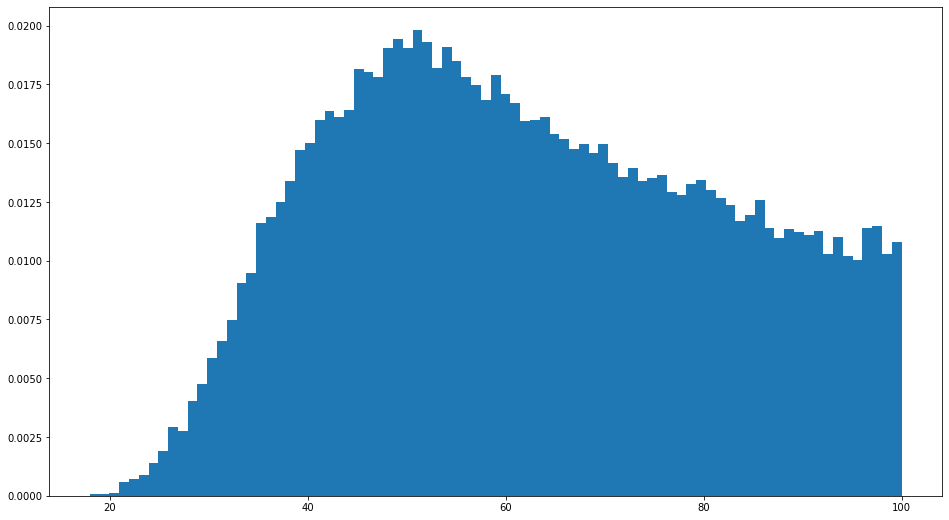

In [137]:
plt.subplots(figsize = (16, 9))
plt.hist(biggest_loop_sizes, bins=max(biggest_loop_sizes) - min(biggest_loop_sizes) + 1, density=True);

Which is  the answer we were looking for. So we sort of shown it, but maybe we can go deeper.

### Sketch of a proof

So I think we have convinced ourselves that the probability of sucess for all prisoners is the same as the probability of the room not having a loop larger than 50. This is clear, but can formalise this a little bit. Specifically can we calculate this probabilty without simulation?

Start with a smaller problem. What is the probability that the largest loop is a given size, say n. For simplicity let's say 50 < n <=100. because that is all we will need, and for less than 50 it is more difficult to compute.

Let's think of the probability that our loop is exactly 100 long.

Pick a random number, let's say it is 1, for simplicity. Now the proability that the loop is not closed is 99/100, only one number would close this loop, the loop cannot be closed otherwise this loop would not be 100 long. Next we need that the loop is not closed, which is to say that the number in the next box is also not 1. The chance of it not being 1 again is 98/99 (one number is no longer possible, we are effectively sampling without replacement). We need this to happen 99 times, each each time the loop is not closed. The final 100th step then closes the loop.

So we have:  $$\Pi_{i=1}^{99}\frac{100 - i}{100 - i + 1}$$

Let's simply compute this.

In [142]:
from functools import reduce

In [144]:
reduce(lambda x, y: x*y, [(100 - i)/(100 - i + 1) for i in range(1, 100)])

0.009999999999999983

In fact the answer is 1/100, seems to be a small rounding error. But we can see that a bit more formally by noting that the above equation is $\frac{99!}{100!} = \frac{1}{100}$.

So we can conclude that the chance that the biggest loop is 100 is 1%, or that the biggest loop is less than 100 is 99%.

The video claims that the probability of the largest loop being size n is 1/n, (provided n>50). The above arguement I used doesn't simply generalise, because with a loop of something other than 100 we have to think about the fact that we choose a random number we might not be on the loop.

Let's think about the case of 99. This is again somewhat special. For this to happen we need a loop of 99 plus one self loop, say the box 1 points back to one.

The probability that 1 points to 1 is 1/100.

The probability that the remaining 99 boxes form a loop is using the same logic as before: $\frac{98!}{99!}$ (becauce we are asking that 99 boxes for a loop now, so we can do the same logic as before but replace 100 with 99. Thus the probability that a group of 99 boxes forms a complete loop is 1/99. So the proability that box one points to itself, and that the others form a complete loop is 1/100*1/99. But we don't care which box forms the self loop, so there are 100 different ways to set this out in fact, so we can multiply by 100, and get back to 1/99. So the formular 1/n also holds for n=99.

Does it also hold more generally? Let's calcualte something more specific. Let's say I choose m boxes at random, what is the chance that every single box in that set of boxes that I choose points to a box that is also within that set. Thus this set forms a closed set of boxes. Note I'm not asking that they form a single loop, they could all point to themselves, or anything in between. The first box has a probability of m/100 of pointing to something in that box. The next box has a probability of (m-1)/99, and so on. For every box in that set to point to another box in that set the probability is $$\frac{m!}{\frac{100!}{(100 - m)!}} = \frac{m!*(100 - m)!}{100!}$$

and further note that this is the inverse of the "choose" function, the number of ways of choosing n items from a set of size 100.

$$C_{m}^{100} = C(m, 100)$$

Now the remaining boxes, what is the probability that they form a "mega-loop" in that they form a single loop. We know already that this is a closed set by extention, if all the other boxes are a closed set, then this must be one too. So we can use the logic that we had before with the group of 100, the probability that a closed set of n boxes forms a single loop is simply 1/100.

So the probability that the room of boxes has a biggest loop of size n with a given configuration (i.e. we specify which boxes are in the loop) is the probability that the first m = (100 - n) boxes form a closed set, and then that the remaining boxes form a single loop is:

$$\frac{1}{C(100 - n, 100})*\frac{1}{n}$$

and note that due to the symetry of the choose function we can also write this as:

$$\frac{1}{C(n, 100})*\frac{1}{n}$$

so this is the probability of finding a biggest loop of size n for a certain configuration, so say I ask the probability of a loop of size 95, but I specify that this consists specifically of the numbers 1 to 95. This is not exactly what we want, but to get to the final answer we simply have to multiply this by the number of specific configurations that there are, there are infact $C(n, 100)$ ways to have this arrangement, so the choice function drops out in each case:

and 

$$p(n) = \frac{1}{n}$$

Let's draw this curve against our data as a sanity check.

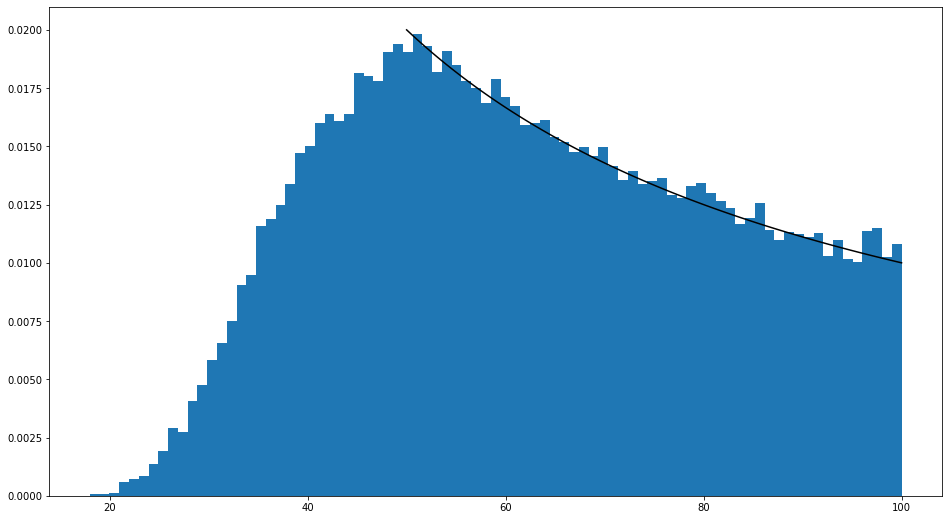

In [161]:
plt.subplots(figsize = (16, 9))
plt.hist(biggest_loop_sizes, bins=max(biggest_loop_sizes) - min(biggest_loop_sizes) + 1, density=True);
x = np.linspace(50, 100, 100)
y = [1/xx for xx in x]
plt.plot(x, y, color='black')

Now note that techincally this is a proof that there is at least one loop of size n, and not that the biggest loop is is of size n, and this formular will hold for all n. But if there is a loop of size n for n > 50 then this must be the biggest loop. That is why the formular holds only for n > 50.

Phew.

So what is the probability of all the prisoners finding their number. This is simply the probability that the biggest loop is not 100 and not 99 and not 98 etc, down to 51.

So:

$$p=1 - \sum_{i=51}^{100}\frac{1}{i}$$

And we can do this simply numerically:

In [162]:
1 - sum([1/i for i in range(51, 101)])

0.3118278206898051

And that is our answer.

### Small Extention

The number 100 seems pretty arbitrary, what happens for other values. You can look through the proof above and find simply replace 100 with whatever. Let's call it m. We only require that m be even (otherwise the setup doesn't quite work).

Now:

$$p=1 - \sum_{i=\frac{m}{2} + 1}^{m}\frac{1}{i}$$

In [155]:
def p(m):
    assert m%2 == 0
    return 1 - sum([1/i for i in range(int(m/2 + 1), m)])

In [163]:
p(1000)

0.3083525694401802

In [173]:
x = range(100, 10000, 2)
y = [p(xx) for xx in x]

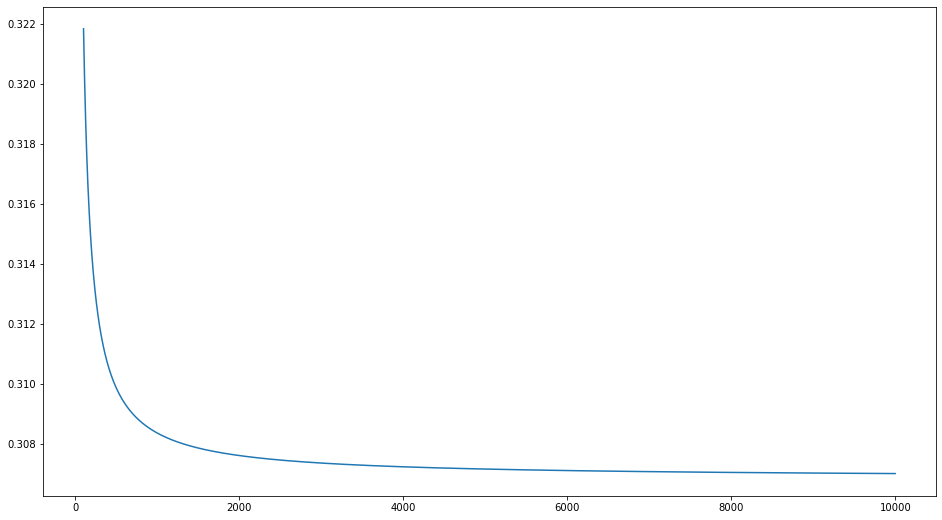

In [174]:
plt.subplots(figsize = (16, 9))
plt.plot(x, y)

It assymptotes to some value. In fact our sum tends to an integral as m goes to infinity. The integral is: 

$$1 - \int_{\frac{1}{2}}^{1}{\frac{1}{x}}dx = 1 - ln(2)$$

Which is:

In [168]:
1 - np.log(2)

0.3068528194400547

Which seems about right. As the numbers get bigger the chance of sucess gets a bit smaller, but it doesn't diminish all that much, and never gets smaller than ln(2) (about 30%).

Done!